In [1]:
#
using Pkg
Pkg.activate(".")
#

  Activating project at `~/control-toolbox/indirect`


# Goddard problem

## Introduction

For this advanced example, we consider the well-known Goddard problem[^1] [^2] which models the ascent of a rocket
through the atmosphere, and we restrict here ourselves to vertical (one dimensional) trajectories. The state variables
are the altitude $r$, speed $v$ and mass $m$ of the rocket during the flight, for a total dimension of 3. The rocket is
subject to gravity $g$, thrust $u$ and drag force $D$ (function of speed and altitude). The final time $t_f$ is free, and the objective is to reach a maximal altitude with a bounded fuel consumption.

We thus want to solve the optimal control problem in Mayer form

$$r(t_f) \to \max$$

subject to the controlled dynamics

$$\dot{r} = v, \quad
    \dot{v} = \frac{T_{\max}\,u - D(r,v)}{m} - g, \quad
    \dot{m} = -u,$$

and subject to the control constraint $u(t) \in [0,1]$. The initial state is fixed while only the final mass is prescribed.

!!! note "Nota bene"

    The Hamiltonian is affine with respect to the control, so singular arcs may occur.


In [1]:
using OptimalControl
t0 = 0      # initial time
r0 = 1      # initial altitude
v0 = 0      # initial speed
m0 = 1      # initial mass
mf = 0.6    # final mass to target

@def ocp begin 

    tf, variable
    t ∈ [ t0, tf ], time
    x ∈ R³, state
    u ∈ R, control

    r = x₁
    v = x₂
    m = x₃

    x(t0) == [ r0, v0, m0 ]
    m(tf) == mf,         (1)
    0 ≤ u(t) ≤ 1
    r(t) ≥ r0

    ẋ(t) == F0(x(t)) + u(t) * F1(x(t))

    r(tf) → max

end;

# Dynamics
const Cd = 310
const Tmax = 3.5
const β = 500
const b = 2

F0(x) = begin
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r - 1)) 
    return [ v, -D/m - 1/r^2, 0 ]
end

F1(x) = begin
    r, v, m = x
    return [ 0, Tmax/m, -b*Tmax ]
end
nothing

We then solve it (by direct method)

In [2]:
direct_sol = solve(ocp, grid_size=100)
nothing # hide

Method = (

:direct, :adnlp, :ipopt)


This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1111

Total number of variables............................:      405
                     variables with only lower bounds:      101
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0100000e+00 9.00e-01 2.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

and plot the solution

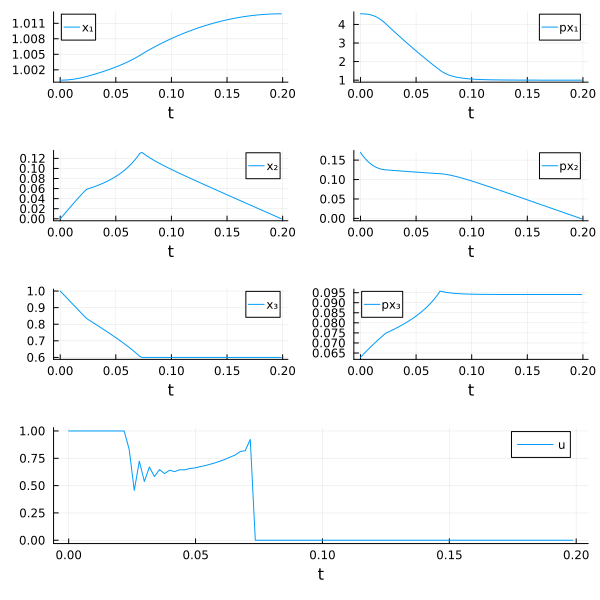

In [3]:
plt = plot(direct_sol, size=(600, 600))
using Plots
Plots.pdf(plt,"./fig-goddard/fig1_goddard.pdf")
display(plt)

## Indirect method

We first determine visually the structure of the optimal solution which is composed of a
bang arc with maximal control, followed by a singular arc and the final
arc is with zero control. Note that the switching function vanishes along the singular.

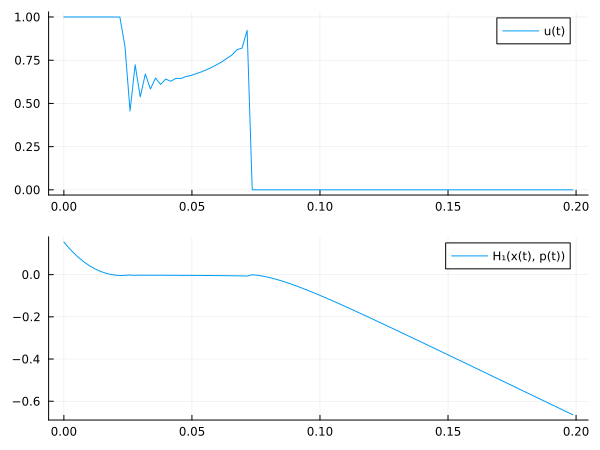

In [4]:
t = direct_sol.times
x = direct_sol.state
u = direct_sol.control
p = direct_sol.costate

H1 = Lift(F1)           # H1(x, p) = p' * F1(x)
φ(t) = H1(x(t), p(t))   # switching function

u_plot  = plot(t, u,     label = "u(t)")
H1_plot = plot(t, φ,     label = "H₁(x(t), p(t))")

plt2 = plot(u_plot, H1_plot, layout=(2,1), size=(600,450))

Plots.pdf(plt2,"./fig-goddard/fig2_goddard.pdf")
display(plt2)

We are now in position to solve the problem by an indirect shooting method. We first define
the three control laws in feedback form and their associated flows. For this we need to
compute some Lie derivatives,
namely [Poisson brackets](https://en.wikipedia.org/wiki/Poisson_bracket) of Hamiltonians
(themselves obtained as lifts to the cotangent bundle of vector fields), or
derivatives of functions along a vector field. For instance, the control along the
*minimal order* singular arcs is obtained as the quotient

$$u_s = -\frac{H_{001}}{H_{101}}$$

of length three Poisson brackets:

$$H_{001} = \{H_0,\{H_0,H_1\}\}, \quad H_{101} = \{H_1,\{H_0,H_1\}\}$$

where, for two Hamiltonians $H$ and $G$,

$$
\{H,G\} := (\nabla_p H|\nabla_x G) - (\nabla_x H|\nabla_p G).
$$

### note "Poisson bracket and Lie derivative"

The Poisson bracket $\{H,G\}$ is also given by the Lie derivative of $G$ along the
Hamiltonian vector field $X_H = (\nabla_p H, -\nabla_x H)$ of $H$, that is
$$
\{H,G\} = X_H \cdot G
$$
which is the reason why we use the `@Lie` macro to compute Poisson brackets below.

With the help of the [differential geometry primitives](https://control-toolbox.org/CTBase.jl/stable/api-diffgeom.html)
from [CTBase.jl](https://control-toolbox.org/docs/ctbase),
these expressions are straightforwardly translated into Julia code:

In [5]:
# Controls
u0 = 0                                  # off control
u1 = 1                                  # bang control

H0 = Lift(F0)                           # H0(x, p) = p' * F0(x)
H01  = @Lie { H0, H1 }
H001 = @Lie { H0, H01 }
H101 = @Lie { H1, H01 }
us(x, p) = -H001(x, p) / H101(x, p)     # singular control

# Flows
f0 = Flow(ocp, (x, p, tf) -> u0)
f1 = Flow(ocp, (x, p, tf) -> u1)
fs = Flow(ocp, (x, p, tf) -> us(x, p))
nothing # hide

Then, we define the shooting function according to the optimal structure we have determined, that is a concatenation of four arcs.

In [6]:
x0 = [ r0, v0, m0 ] # initial state

function shoot!(s, p0, t1, t2, tf)

    x1, p1 = f1(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    xf, pf = f0(t2, x2, p2, tf)

    s[1] = constraint(ocp, :eq1)(x0, xf, tf) - mf # final mass constraint (1)
    s[2:3] = pf[1:2] - [ 1, 0 ]                   # transversality conditions
    s[4] = H1(x1, p1)                             # H1 = H01 = 0
    s[5] = H01(x1, p1)                            # at the entrance of the singular arc
    s[6] = H0(xf, pf)                             # since tf is free

end
nothing # hide

To solve the problem by an indirect shooting method, we then need a good initial guess, that is a good approximation of the initial costate, the two switching times and the final time.

In [7]:
η = 0.003
t13 = t[ abs.(φ.(t)) .≤ η ]
p0 = p(t0)
t1 = min(t13...)
t2 = max(t13...)
tf = t[end]

println("p0 = ", p0)
println("t1 = ", t1)
println("t2 = ", t2)
println("tf = ", tf)

# Norm of the shooting function at solution
using LinearAlgebra: norm
s = similar(p0, 6)
#@suppress_err begin # hide
shoot!(s, p0, t1, t2, tf)
#end # hide
println("Norm of the shooting function: ‖s‖ = ", norm(s), "\n")

p0 = 

[4.571654305662809, 0.16976525423124872, 0.06281170860424513]
t1 = 0.017889340999665236
t2 = 0.0735450685541793
tf = 0.19877045555183598


┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/gergaud/.julia/packages/SciMLBase/xNo9N/src/performance_warnings.jl:32


Norm of the shooting function: ‖s‖ = 3.896498216957371



Finally, we can solve the shooting equations thanks to the MINPACK solver.

In [8]:
using MINPACK                                               # NLE solver

nle = (s, ξ) -> shoot!(s, ξ[1:3], ξ[4], ξ[5], ξ[6])   # auxiliary function
                                                            # with aggregated inputs
ξ = [ p0 ; t1 ; t2 ; tf ]                              # initial guess
global indirect_sol =      # hide
#@suppress_err begin # hide
#fsolve(nle, ξ)      # hide
indirect_sol = fsolve(nle, ξ)                               # resolution of S(ξ) = 0
#end                 # hide

# we retrieve the costate solution together with the times
p0 = indirect_sol.x[1:3]
t1 = indirect_sol.x[4]
t2 = indirect_sol.x[5]
tf = indirect_sol.x[6]

println("p0 = ", p0)
println("t1 = ", t1)
println("t2 = ", t2)
println("tf = ", tf)

# Norm of the shooting function at solution
s = similar(p0, 6)
#@suppress_err begin # hide
shoot!(s, p0, t1, t2, tf)
#end # hide
println("Norm of the shooting function: ‖s‖ = ", norm(s), "\n")

p0 = [4.572900232255367, 0.17429930987281977, 0.0622497535253444]
t1 = 0.023509684042576112
t2 = 0.07267074343915193
tf = 0.198856262103485
Norm of the shooting function: ‖s‖ = 4.354047180939318e-12



We plot the solution of the indirect solution (in red) over the solution of the direct method (in blue).

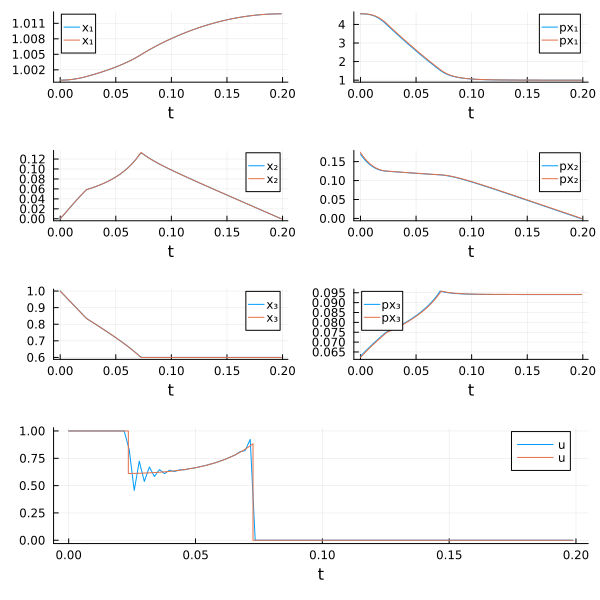

In [9]:
f = f1 * (t1, fs) * (t2, f0)   # concatenation of the flows
flow_sol = f((t0, tf), x0, p0) # compute the solution: state, costate, control...

plot!(plt, flow_sol)
Plots.pdf(plt,"./fig-goddard/fig3_goddard.pdf")
display(plt)

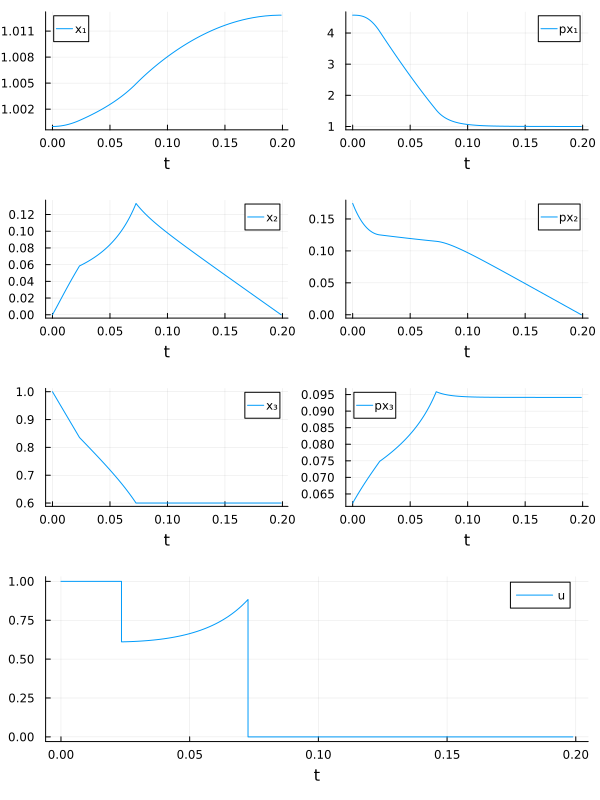

In [10]:
plt_goddard = plot(flow_sol,size=(600, 800))
Plots.pdf(plt_goddard,"./fig-goddard/fig4_goddard.pdf")
display(plt_goddard)

## References

[^1]: R.H. Goddard. A Method of Reaching Extreme Altitudes, volume 71(2) of Smithsonian Miscellaneous Collections. Smithsonian institution, City of Washington, 1919.

[^2]: H. Seywald and E.M. Cliff. Goddard problem in presence of a dynamic pressure limit. Journal of Guidance, Control, and Dynamics, 16(4):776–781, 1993.